In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from keras.datasets import mnist
from sklearn.metrics import accuracy_score

# Nhận diện vị trí biển số xe trên image

Text(0.5, 1.0, 'dilated_image')

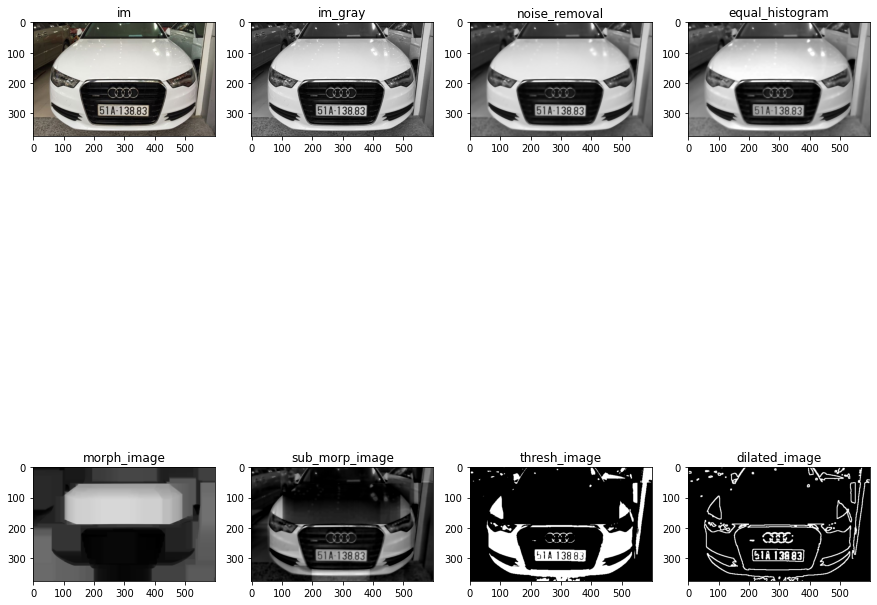

In [2]:
# Load image
im = cv2.imread("./car1.jpg")

# Chuyển ảnh về không gian màu xám
im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

# Giảm nhiễu làm cho các cạnh sắc nét hơn
noise_removal = cv2.bilateralFilter(im_gray,9,75,75)
# Cân bằng sáng tối hình ảnh
equal_histogram = cv2.equalizeHist(noise_removal)

# Biến đổi hình thái ảnh làm cho edge trở nên sắc nhọn
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
morph_image = cv2.morphologyEx(equal_histogram,cv2.MORPH_OPEN,kernel,iterations=20)

# Xóa background, tách biệt background và vùng sáng
sub_morp_image = cv2.subtract(equal_histogram,morph_image)
ret,thresh_image = cv2.threshold(sub_morp_image,0,255,cv2.THRESH_OTSU)

# Nhận dạng edge bằng thuật toán Canny
canny_image = cv2.Canny(thresh_image,250,255)

# Dilate các edge 
kernel = np.ones((3,3), np.uint8)
dilated_image = cv2.dilate(canny_image,kernel,iterations=1)

fig, axes = plt.subplots(2, 4, figsize=(15, 15)) 
axes[0][0].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
axes[0][0].set_title('im')
axes[0][1].imshow(cv2.cvtColor(im_gray, cv2.COLOR_BGR2RGB))
axes[0][1].set_title('im_gray')
axes[0][2].imshow(cv2.cvtColor(noise_removal, cv2.COLOR_BGR2RGB))
axes[0][2].set_title('noise_removal')
axes[0][3].imshow(cv2.cvtColor(equal_histogram, cv2.COLOR_BGR2RGB))
axes[0][3].set_title('equal_histogram')
axes[1][0].imshow(cv2.cvtColor(morph_image, cv2.COLOR_BGR2RGB))
axes[1][0].set_title('morph_image')
axes[1][1].imshow(cv2.cvtColor(sub_morp_image, cv2.COLOR_BGR2RGB))
axes[1][1].set_title('sub_morp_image')
axes[1][2].imshow(cv2.cvtColor(thresh_image, cv2.COLOR_BGR2RGB))
axes[1][2].set_title('thresh_image')
axes[1][3].imshow(cv2.cvtColor(dilated_image, cv2.COLOR_BGR2RGB))
axes[1][3].set_title('dilated_image')

In [3]:
# Tìm các countour từ dilated image
contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Lấy 10 contour có diện tích lớn nhất
contours= sorted(contours, key = cv2.contourArea, reverse = True)[:10]
location = None
for c in contours:
    peri = cv2.arcLength(c, True)
    # Xấp xỉ đa giác
    approx = cv2.approxPolyDP(c, 0.05 * peri, True) 
    # Nếu tìm được 4 đỉnh của hình chữ nhật -> lưu lại vị trí tọa độ 4 đỉnh
    if len(approx) == 4:
            location = approx
            break

In [4]:
location

array([[[211, 275]],

       [[215, 309]],

       [[381, 310]],

       [[379, 271]]], dtype=int32)

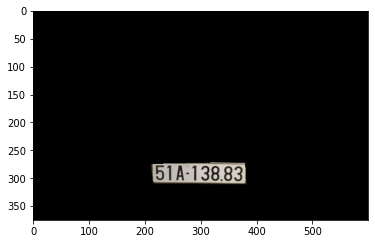

In [5]:
# Cắt biển số xe ra khỏi ảnh
mask = np.zeros(im_gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(im, im, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

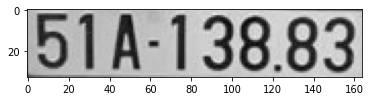

In [6]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = im_gray[x1+4:x2-2, y1+4:y2-2]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

# Segmentation các kí tự có trên biển số xe

In [7]:
# Tương tự bước nhận dạng để tìm contour
roi = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
roi_gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
roi_blur = cv2.GaussianBlur(roi_gray,(3,3),1)
ret,thre = cv2.threshold(roi_blur,120,255,cv2.THRESH_BINARY_INV)
kerel3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
thre_mor = cv2.morphologyEx(thre,cv2.MORPH_DILATE,kerel3)
cont,hier = cv2.findContours(thre_mor,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

[2.0, 15.5, 31.5, 29.0, 4.0, 19.0, 31.0, 29.0, 256.5, 378.5, 377.5, 267.0, 131.0, 273.5, 142.5, 309.0]


C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


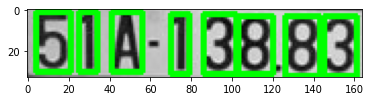

In [8]:
# Dựa trên cropped_image chọn ra 7 vùng có diện tích tương đương
areas_ind = {}
areas = []
# Tính diện tích các vùng
for ind,cnt in enumerate(cont) :
    area = cv2.contourArea(cnt)
    areas_ind[area] = ind
    areas.append(area)
print(areas)

# Sắp xếp diện tích và chọn ra 8 vùng diện tích lớn nhất
areas = sorted(areas,reverse=True)[0:8]
contours = []
for i in areas:
    (x,y,w,h) = cv2.boundingRect(cont[areas_ind[i]])
    cv2.rectangle(roi,(x,y),(x+w,y+h),(0,255,0),2)
    contours.append(cont[areas_ind[i]])

contours = np.array(contours)

plt.imshow(cv2.cvtColor(roi,cv2.COLOR_BGR2RGB))

In [9]:
# Sắp xếp lại các contour đã nhận dạng đúng về vị trí ban đầu
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# Nhận dạng 

In [10]:
from string import ascii_uppercase
from sklearn.model_selection import train_test_split
# Load dataset mnist: chữ số viết tay
(X_digit_train,y_digit_train),(X_digit_test,y_digit_test) = mnist.load_data()
# Load dataset alphabet: A_Z
alpha_data = pd.read_csv('A_Z Handwritten Data.csv')
X_alpha = alpha_data.iloc[:,1:].values
y_alpha = alpha_data.iloc[:,0].values

In [14]:
alphabet = np.array(list(ascii_uppercase))
y_al = alphabet[y_alpha]
X_alpha = X_alpha.reshape(-1, 28, 28)
y_al

array(['A', 'A', 'A', ..., 'Z', 'Z', 'Z'], dtype='<U1')

In [15]:
X_alpha_train, X_alpha_test, y_alpha_train, y_alpha_test = train_test_split(X_alpha, y_al, test_size = 0.3, random_state = 42)

In [16]:
X_train = np.concatenate((X_digit_train, X_alpha_train), axis = 0)
X_test = np.concatenate((X_digit_test, X_alpha_test), axis = 0)
y_train = np.concatenate((y_digit_train, y_alpha_train))
y_test = np.concatenate((y_digit_test, y_alpha_test))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 84)


In [17]:
# X_train
X_train_feature = []
for i in range(len(X_train)):
    feature = hog(X_train[i],orientations=9,pixels_per_cell=(14,14),cells_per_block=(1,1),block_norm="L2")
    X_train_feature.append(feature)
X_train_feature = np.array(X_train_feature,dtype = np.float32)

# x_val
X_val_feature = []
for i in range(len(X_val)):
    feature = hog(X_val[i],orientations=9,pixels_per_cell=(14,14),cells_per_block=(1,1),block_norm="L2")
    X_val_feature.append(feature)
X_val_feature = np.array(X_val_feature,dtype = np.float32)

# x_test
X_test_feature = []
for i in range(len(X_test)):
    feature = hog(X_test[i],orientations=9,pixels_per_cell=(14,14),cells_per_block=(1,1),block_norm="L2")
    X_test_feature.append(feature)
X_test_feature = np.array(X_test_feature,dtype=np.float32)

In [18]:
model = LinearSVC(C = 10)
model.fit(X_train_feature,y_train)
y_pre = model.predict(X_val_feature)
print(accuracy_score(y_val,y_pre))

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7722080756638777


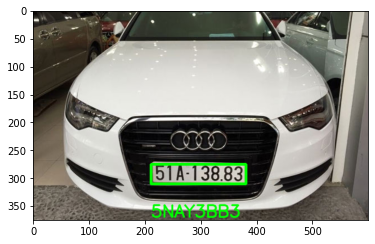

In [20]:
text = ""
for contour in contours:
    (x,y,w,h) = cv2.boundingRect(contour)
    roi = thre[y:y+h,x:x+w]
    roi = np.pad(roi,(20,20),'constant',constant_values=(0,0))
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    
    # Calculate the HOG features
    roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1),block_norm="L2")
    nbr = model.predict(np.array([roi_hog_fd], np.float32))
    text += str(nbr[0])

font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(im, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(im, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))